## Imports

In [164]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
import pandas as pd
import numpy as np
import sys, os, time, datetime
import matplotlib.pyplot as plt


sys.path.append('libraries')
import signal_processing as spl 
import prediction_lib as pl
pl = reload(pl)
spl = reload(spl)

In [165]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors
import pandas as pd
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.decomposition import PCA
from tqdm import tqdm
import sys
from scipy import optimize
from IPython import display
from collections import Counter
from sklearn.externals import joblib

from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from python_speech_features import mfcc

##  Load in Signal DF

In [166]:
load = True
name = 'perfect_dataset'
INPUT_FILE = 'data/%s.csv' % name
out_name = 'results/%s_RESULTS.csv' % name

In [168]:
if load and os.path.exists(out_name):
    RESULTS_DF = pd.read_csv(out_name, index_col = 0)
    RESULTS_DF.head()
else:
    RESULTS_DF = None


,ACCURACY_WO_SPACES,DO_ALL,INPUT_FILE,MAX_COLS,MFCC_START,MODEL,NUM_CLUSTERS,N_COMPONENTS,OVERALL_ACCURACY,PREDICTION,RATE,SCORE,SMOOTH,TOL,WHITEN
40:43.5,0.198697,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.261222,ar he the heronnglo te heo asar t ler is toffo...,44100,-13719.30846,0.018316,0.01,False
45:18.2,0.088672,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.170866,alear war prcoustea ll pro ff y o wof mp fofro...,44100,-13907.03187,0.018316,0.01,False
52:27.7,0.131741,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.209962,ornor dad buranntre bl bed sber lored on bulbu...,44100,-13778.96296,0.018316,0.01,False
53:09.3,0.218241,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.279757,isnis sas hetindund st hes ksct hived it windi...,44100,-13591.70647,0.049787,0.01,False
54:44.9,0.175172,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.258326,ullus sas hequllore te hes orct pares ar busqu...,44100,-13680.91513,0.135335,0.01,False


In [169]:
char_inps_raw = pd.read_csv(INPUT_FILE, index_col=0)
char_inps_raw['char'] = char_inps_raw['char'].fillna(' ').replace('#SPACE', ' ')
# char_inps_raw['peak_diff'] =char_inps_raw['peak_diff'].fillna(0)
char_inps_raw = char_inps_raw.fillna(0)
char_inps_raw.tail(10)

,peak time,char,start time,end time,signal,0,1,2,3,4,...,15425,15426,15427,15428,15429,15430,15431,15432,15433,15434
3443,1205.164819,,1205.129819,1205.479819,0.000357,-0.100998,-0.015492,0.084944,0.022892,0.118922,...,0.988503,0.888722,1.186432,1.165176,0.144874,0.252931,0.142511,0.196231,1.019574,0.243095
3444,1205.536387,o,1205.501387,1205.851387,0.000357,0.605787,0.673882,0.841651,0.465785,0.397254,...,-3.536588,5.058556,5.898054,6.116207,6.306228,-10.719934,5.384215,18.141334,-3.398774,4.310902
3445,1205.602626,u,1205.567626,1205.917626,0.000357,0.370805,0.367855,0.193740,0.271778,0.217057,...,-0.052352,0.434728,0.559545,-0.040595,-0.744939,-0.705834,-0.345340,-0.434586,-0.457719,-0.302066
3446,1205.869425,t,1205.834425,1206.184425,0.000357,0.574571,0.536336,0.310582,0.287124,0.468396,...,7.602115,-4.575600,1.406101,-2.978368,1.717977,11.550069,-4.738052,-4.291237,-3.474019,-3.132150
3447,1206.152522,,1206.117522,1206.467522,0.000357,0.431744,0.391007,0.554542,0.688468,0.681929,...,-1.686501,-1.405832,-1.132361,-1.400418,-1.635337,-1.081181,-0.747627,-0.437727,-0.078946,-0.597740
3448,1206.603440,a,1206.568440,1206.918440,0.000357,-0.032560,0.000937,-0.072859,-0.052033,-0.111156,...,-0.053287,0.107539,0.242174,0.231995,0.234771,0.165148,0.217436,0.225331,-0.098057,-0.262253
3449,1206.880633,g,1206.845633,1207.195633,0.000357,0.993742,2.423808,1.609095,3.906103,-1.916781,...,-0.214781,-0.203393,-0.293734,-0.352500,-0.279817,-0.146706,-0.194231,-0.147599,-0.075321,-0.133153
3450,1207.134864,a,1207.099864,1207.449864,0.000357,-0.241887,-0.305712,-0.413097,-0.455908,-0.563319,...,-3.410009,3.432781,1.741468,1.822611,1.289886,-0.678719,-1.402292,2.042433,3.062629,0.586512
3451,1207.493027,i,1207.458027,1207.808027,0.000357,1.338969,-2.046932,-1.036754,1.714020,-0.265125,...,0.044424,-0.199461,-0.242156,0.118358,0.091515,-0.106329,-0.103860,-0.028796,-0.180932,-0.132623
3452,1207.817996,n,1207.782996,1208.132996,0.000357,-0.326185,-0.451966,-0.480052,-0.572480,-0.523397,...,0.584964,0.403560,0.429286,0.358761,0.257468,0.414053,0.427385,0.309221,0.406631,0.378481


In [170]:
targ_s = ''.join(char_inps_raw['char'].values)
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book without pictures or conversations so she was considering in her own mind as well as she could for the day made her feel very sleepy and stupid whether the pleasure of making a daisy chai would be worth the trouble of getting up and picking the daisies when sudenly a white rabbit with pink eyes ran close by her there was nothing as remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself oh dear oh dear i shall be too late when she thought it over afterwards it occurred to her that she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually took a watch out of its pocket and burning with curiosity she ran across the field after it and was just about to 

In [171]:
PARAM_RESULTS ={}

## Processing 

In [174]:
RATE = 44100
WHITEN = True
SAVE_THRESH= 0.35
TOL = 1e-2

should_loop = True


MAX_COLS = -5000
MFCC_START = 0
MFCC_END = -20
NUM_CLUSTERS = 50
N_COMPONENTS = 240
DO_ALL = False


REPEATS = 5
SMOOTHS = map(lambda x : np.exp(x), range(-8, 8))

In [ ]:
def build_params(smooth):
    _id = datetime.datetime.now()
    PARAM_RESULTS[_id] = {'RATE' : RATE,
        'TOL' : TOL,
        'INPUT_FILE' : INPUT_FILE,
         'MAX_COLS': MAX_COLS,
          'NUM_CLUSTERS' : NUM_CLUSTERS,
          'N_COMPONENTS' : N_COMPONENTS,
          'MFCC_START' : MFCC_START,
          'MFCC_START' : MFCC_START,
          'WHITEN' : WHITEN,
          'DO_ALL' : DO_ALL,
          'SMOOTH' : smooth,
          'PREDICTION' : None,
          'ACCURACY_WO_SPACES' : None,
         'OVERALL_ACCURACY' : None,
         'SCORE' : None,
         'MODEL' : None
                          
         }
    return PARAM_RESULTS[_id], _id

def save(model = None, accuracy = None, _id = None):
    global RESULTS_DF
    if RESULTS_DF is not None:
        RESULTS_DF = RESULTS_DF.append(pd.DataFrame(PARAM_RESULTS).T).drop_duplicates()
    else:
        RESULTS_DF = pd.DataFrame(PARAM_RESULTS).T
    RESULTS_DF.to_csv(out_name)
    
    if model:
        joblib.dump(model, "models/%s-%s.pkl" % (_id, accuracy))
    
    by_smooth = RESULTS_DF[['ACCURACY_WO_SPACES','OVERALL_ACCURACY', 'SMOOTH']].dropna().astype(float).groupby('SMOOTH')
    print 'max'
    display.display(by_smooth.max().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False))
    print 'mean'
    display.display(by_smooth.mean().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False))
    print 'var'
    display.display(by_smooth.var().sort_values(['OVERALL_ACCURACY', 'ACCURACY_WO_SPACES'], ascending =False))


def loop():
    
    # Copy and take subset
    char_inps = char_inps_raw[char_inps_raw.columns[:MAX_COLS]].copy()
    
    # Extract features
    cepstrum_df = pl.extract_cepstrum(char_inps, RATE, mfcc_start=MFCC_START, mfcc_end=MFCC_END)
    
    # Cluster the sounds
    cepstrum_df = pl.cluster(cepstrum_df, num_clusters = NUM_CLUSTERS, n_components = N_COMPONENTS)
    
    # Repeat the hmm experiement for each parameter
    for _ in range(REPEATS):
        # For each smoothing parameter to be tested
        for smooth in SMOOTHS:
            
            
            estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                    NUM_CLUSTERS, t_smooth = smooth, tol = TOL,
                                                    do_all = DO_ALL, verbose = False)  
            print smooth, acc, acc_wospace
            params,_id = build_params(smooth)
            params['OVERALL_ACCURACY'] = acc
            params['ACCURACY_WO_SPACES'] = acc_wospace
            params['PREDICTION'] = estimate
            params['SCORE'] = score
            params['MODEL'] = hmm
            
            if acc > SAVE_THRESH:
                save(hmm, acc, _id)
            else:
                save()
if should_loop:
    loop()

0.000335462627903 0.13437590501 0.0712993123417
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN
0.002479,NaN,NaN


0.000911881965555 0.126846220678 0.0694896851249
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN
0.000912,NaN,NaN


0.00247875217667 0.121054155807 0.0593557727108
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN
0.000912,NaN,NaN


0.00673794699909 0.117868520127 0.0600796235975
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN
0.000912,NaN,NaN


0.0183156388887 0.123370981755 0.0593557727108
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN
0.000912,NaN,NaN


0.0497870683679 0.126846220678 0.0662323561346
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN
0.000912,NaN,NaN


0.135335283237 0.133507095279 0.0745566413319
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN
0.000912,NaN,NaN


0.367879441171 0.125977410947 0.0676800579081
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN
0.000912,NaN,NaN


1.0 0.123660584999 0.0684039087948
max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222
0.135335,0.175172,0.258326
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950
0.000123,0.164133,0.235303
0.135335,0.121607,0.210542
0.018316,0.114730,0.194107


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.135335,0.005738,0.004567
0.018316,0.004544,0.002955
0.000123,0.002052,0.001797
0.049787,0.001553,0.000995
1.000000,0.000035,0.000507
0.000335,0.000205,0.000035
0.000045,NaN,NaN
0.000335,NaN,NaN
0.000912,NaN,NaN


In [159]:
save()

max


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
2.718282,0.223308,0.282653
0.049787,0.218241,0.279757
0.049787,0.218241,0.279757
0.000335,0.201592,0.270779
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.000123,0.196164,0.265277
0.018316,0.198697,0.261222


mean


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
2.718282,0.223308,0.282653
2.718282,0.223308,0.282653
0.000335,0.201592,0.270779
0.000335,0.201592,0.270779
0.006738,0.200145,0.269621
0.049787,0.190373,0.257457
0.049787,0.190373,0.257457
0.000045,0.178429,0.253403
0.367879,0.167210,0.240950


var


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.006053,0.004082
0.135335,0.003826,0.003044
0.018316,0.004225,0.002857
0.018316,0.004225,0.002857
0.000123,0.001368,0.001198
0.049787,0.001553,0.000995
0.049787,0.001553,0.000995
0.000045,0.000000,0.000000
0.000912,0.000000,0.000000


In [160]:
RESULTS_DF

,ACCURACY_WO_SPACES,DO_ALL,INPUT_FILE,MAX_COLS,MFCC_START,MODEL,NUM_CLUSTERS,N_COMPONENTS,OVERALL_ACCURACY,PREDICTION,RATE,SCORE,SMOOTH,TOL,Unnamed: 0.1,WHITEN
0,0.198697,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.261222,ar he the heronnglo te heo asar t ler is toffo...,44100,-13719.3,0.0183156,0.01,2016-12-02 06:40:43.549521,True
1,0.0886717,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.170866,alear war prcoustea ll pro ff y o wof mp fofro...,44100,-13907,0.0183156,0.01,2016-12-02 06:45:18.224001,True
2016-12-02 06:52:27.662817,0.131741,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.209962,ornor dad buranntre bl bed sber lored on bulbu...,44100,-13779,0.0183156,0.01,NaN,True
2016-12-02 06:53:09.277172,0.218241,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.279757,isnis sas hetindund st hes ksct hived it windi...,44100,-13591.7,0.0497871,0.01,NaN,True
2016-12-02 06:54:44.864985,0.175172,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.258326,ullus sas hequllore te hes orct pares ar busqu...,44100,-13680.9,0.135335,0.01,NaN,True
2016-12-02 06:56:18.901980,0.16721,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.24095,arlur war hesplldle be her oris parer he mprsp...,44100,-13781.1,0.367879,0.01,NaN,True
2016-12-02 06:58:06.689375,0.0600796,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.155517,hewhe she arevexper ts the cere avert he theev...,44100,-13737.7,1,0.01,NaN,True
2016-12-02 06:59:31.740486,0.223308,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.282653,idnis sas hetindund ts hes edat inded is dindi...,44100,-13722.5,2.71828,0.01,NaN,True
2016-12-02 07:03:55.650064,0.132103,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.205329,amppo opoulolinthecurk bor brelulisby ar bofra...,44100,-13801.3,0.00012341,0.01,NaN,True
2016-12-02 07:05:26.035054,0.201592,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.270779,anive whe hetinncon ss hes nd t tithe is tissi...,44100,-13834.7,0.000335463,0.01,NaN,True


# Visualizing process 

In [90]:
char_inps = char_inps_raw.copy()
char_inps = char_inps_raw[char_inps_raw.columns[:MAX_COLS]].copy()
char_inps.tail(10)

,peak time,char,start time,end time,signal,0,1,2,3,4,...,11425,11426,11427,11428,11429,11430,11431,11432,11433,11434
3443,1205.164819,,1205.129819,1205.479819,0.000357,-0.100998,-0.015492,0.084944,0.022892,0.118922,...,0.168675,0.104802,0.156872,0.168721,0.252497,0.181949,0.130980,0.104746,0.014904,0.011887
3444,1205.536387,o,1205.501387,1205.851387,0.000357,0.605787,0.673882,0.841651,0.465785,0.397254,...,1.026073,1.133255,0.993214,0.568383,0.159201,0.294078,0.393203,0.264616,0.011605,-0.517499
3445,1205.602626,u,1205.567626,1205.917626,0.000357,0.370805,0.367855,0.193740,0.271778,0.217057,...,-0.416274,-0.250754,-0.261554,-0.349911,-0.330273,-0.436647,-0.434013,-0.540850,-0.704286,-0.546931
3446,1205.869425,t,1205.834425,1206.184425,0.000357,0.574571,0.536336,0.310582,0.287124,0.468396,...,-0.042122,-0.023789,0.096870,0.189113,0.045593,0.014316,0.308513,0.331150,0.230743,0.452211
3447,1206.152522,,1206.117522,1206.467522,0.000357,0.431744,0.391007,0.554542,0.688468,0.681929,...,0.124431,0.035797,0.218297,0.062395,-0.011980,-0.044453,-0.253223,-0.276595,-0.277005,-0.141732
3448,1206.603440,a,1206.568440,1206.918440,0.000357,-0.032560,0.000937,-0.072859,-0.052033,-0.111156,...,-1.283691,-0.794363,-0.201900,-1.860820,-9.432899,-6.809749,-2.785248,-1.370712,-3.377631,-1.287131
3449,1206.880633,g,1206.845633,1207.195633,0.000357,0.993742,2.423808,1.609095,3.906103,-1.916781,...,-0.628927,-0.497646,-0.363780,-0.422035,-0.401987,-0.354951,-0.417962,-0.504944,-0.494354,-0.350511
3450,1207.134864,a,1207.099864,1207.449864,0.000357,-0.241887,-0.305712,-0.413097,-0.455908,-0.563319,...,0.464280,0.016643,-0.191193,-0.328831,0.049546,-0.022110,-0.386810,-0.110086,-0.156554,0.049690
3451,1207.493027,i,1207.458027,1207.808027,0.000357,1.338969,-2.046932,-1.036754,1.714020,-0.265125,...,-2.242153,-2.497489,-1.916969,-2.618373,-2.784097,-1.843260,-2.305395,-2.787854,-2.295095,-2.846533
3452,1207.817996,n,1207.782996,1208.132996,0.000357,-0.326185,-0.451966,-0.480052,-0.572480,-0.523397,...,0.279314,0.243391,0.176626,0.032393,0.075006,0.206661,0.040417,0.072557,0.261592,0.163983


## Visualize Spaces 

8
Visualizing:  


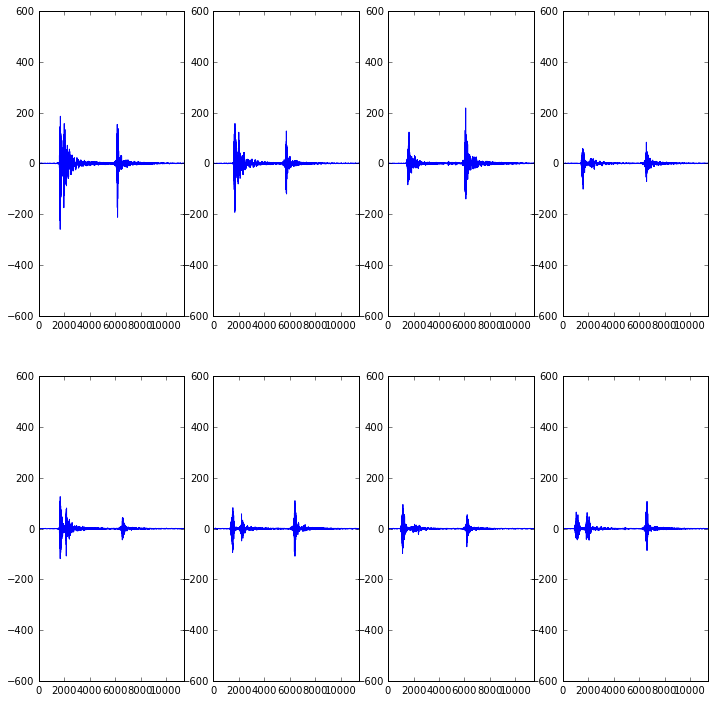

In [91]:
pl.view_char(char_inps, ' ', limit = 8, xlim = 600)

8
Visualizing: e


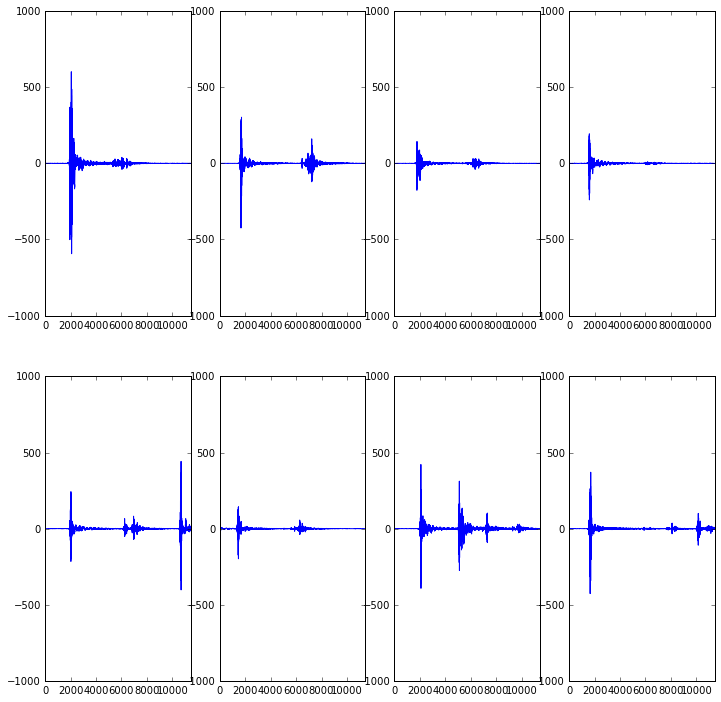

In [92]:
pl.view_char(char_inps, 'e', limit = 8, xlim = 1000)

## Get the cepstrum features from the raw signal 

In [94]:
 # Extract features
cepstrum_df = pl.extract_cepstrum(char_inps, RATE, mfcc_start=MFCC_START, mfcc_end=MFCC_END)

cepstrum_df.head()

,char,0,1,2,3,4,5,6,7,8,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
0,a,-0.189109,-15.886053,2.920755,-2.581344,-0.511456,3.492524,2.178309,0.429753,-14.802668,...,9.568374,13.065884,-8.748414,5.811014,7.500274,17.407786,20.072992,10.652197,-20.097767,-3.762298
1,l,0.588344,-14.107132,6.515267,-5.201988,-5.922548,4.140115,6.859408,15.315225,0.239580,...,1.144932,19.559323,2.595354,-0.361889,-4.218561,-2.940876,11.128792,1.166683,-7.262922,-7.495341
2,i,0.881511,-16.656505,2.620335,-1.980704,-0.755889,-4.924566,-4.382265,-7.269037,-17.614677,...,4.595249,0.213774,-6.265409,7.121648,-3.525256,-14.495574,2.034009,-7.899800,-14.530836,-17.337898
3,c,1.044617,-11.092778,8.965266,-0.268542,1.385006,-0.867237,-6.515486,3.125465,-15.163651,...,-15.915712,-0.934091,-18.151780,-17.397042,16.028316,5.977620,-9.005824,6.250085,-17.246079,-6.226176
4,e,1.311194,-15.052079,4.706996,-4.647840,-11.586465,-9.165854,-8.466227,7.140590,-2.125785,...,0.943415,7.101389,-3.889629,6.826637,-0.184211,8.109318,7.674377,-5.375599,-4.361769,-5.214041


In [105]:
inds = cepstrum_df.dtypes == np.float64
pca = PCA(n_components=N_COMPONENTS)
pca.fit(cepstrum_df.ix[:, inds].values)
data = pca.transform(cepstrum_df.ix[:, inds].values)

PCA(copy=True, n_components=200, whiten=False)

In [106]:
pca.explained_variance_ratio_.sum()

0.72709582512333482

## Visualize Cepstrum Features 

12
Visualizing:  


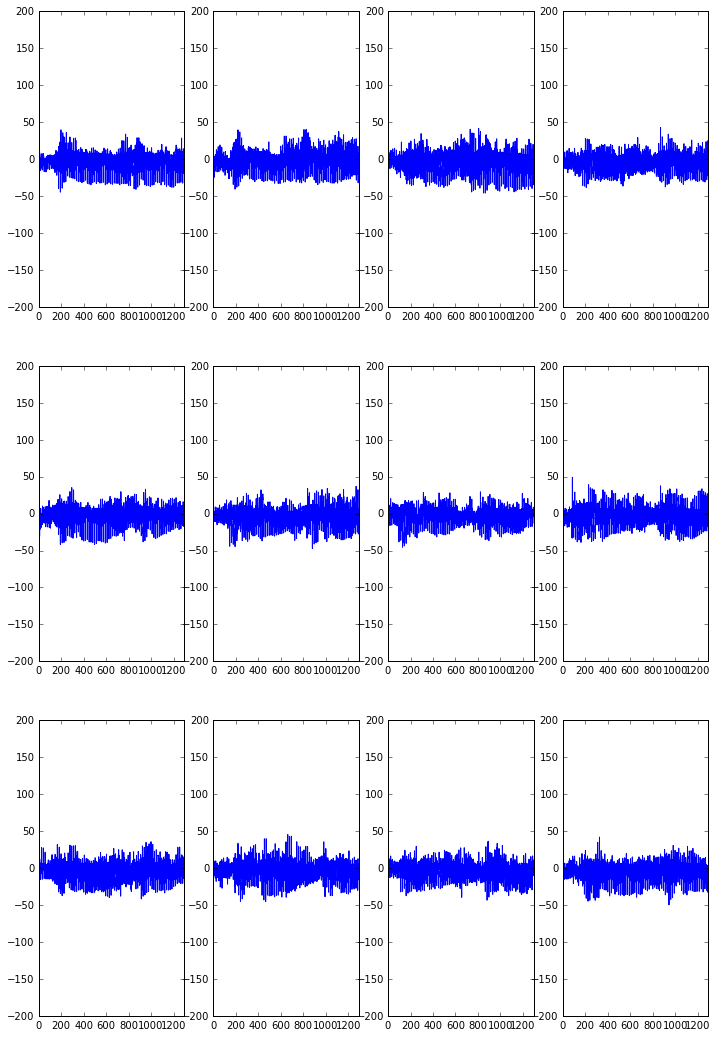

In [107]:
pl.view_char(cepstrum_df, ' ', xlim = 200, limit = 12)

12
Visualizing: e


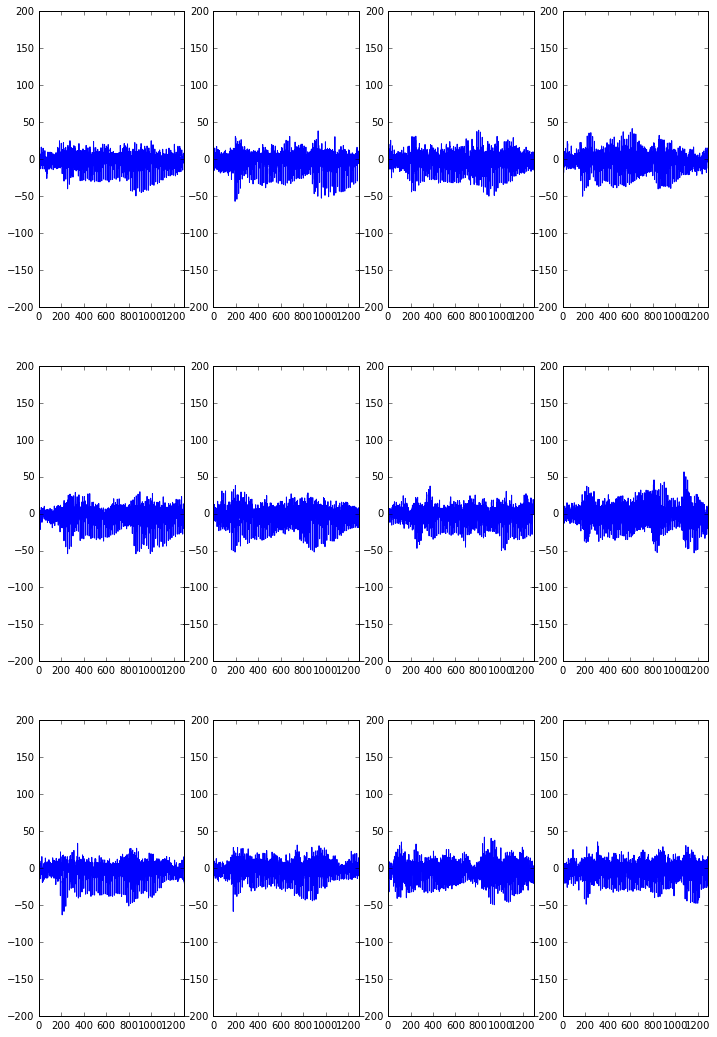

In [108]:
pl.view_char(cepstrum_df, 'e', xlim = 200, limit = 12)

## Cluster the features

In [109]:
# Cluster the sounds
cepstrum_df = pl.cluster(cepstrum_df, num_clusters = NUM_CLUSTERS, n_components = N_COMPONENTS)
cepstrum_df.head()

,char,0,1,2,3,4,5,6,7,8,...,1287,1288,1289,1290,1291,1292,1293,1294,1295,cluster
0,a,-0.189109,-15.886053,2.920755,-2.581344,-0.511456,3.492524,2.178309,0.429753,-14.802668,...,13.065884,-8.748414,5.811014,7.500274,17.407786,20.072992,10.652197,-20.097767,-3.762298,18
1,l,0.588344,-14.107132,6.515267,-5.201988,-5.922548,4.140115,6.859408,15.315225,0.239580,...,19.559323,2.595354,-0.361889,-4.218561,-2.940876,11.128792,1.166683,-7.262922,-7.495341,39
2,i,0.881511,-16.656505,2.620335,-1.980704,-0.755889,-4.924566,-4.382265,-7.269037,-17.614677,...,0.213774,-6.265409,7.121648,-3.525256,-14.495574,2.034009,-7.899800,-14.530836,-17.337898,5
3,c,1.044617,-11.092778,8.965266,-0.268542,1.385006,-0.867237,-6.515486,3.125465,-15.163651,...,-0.934091,-18.151780,-17.397042,16.028316,5.977620,-9.005824,6.250085,-17.246079,-6.226176,43
4,e,1.311194,-15.052079,4.706996,-4.647840,-11.586465,-9.165854,-8.466227,7.140590,-2.125785,...,7.101389,-3.889629,6.826637,-0.184211,8.109318,7.674377,-5.375599,-4.361769,-5.214041,46


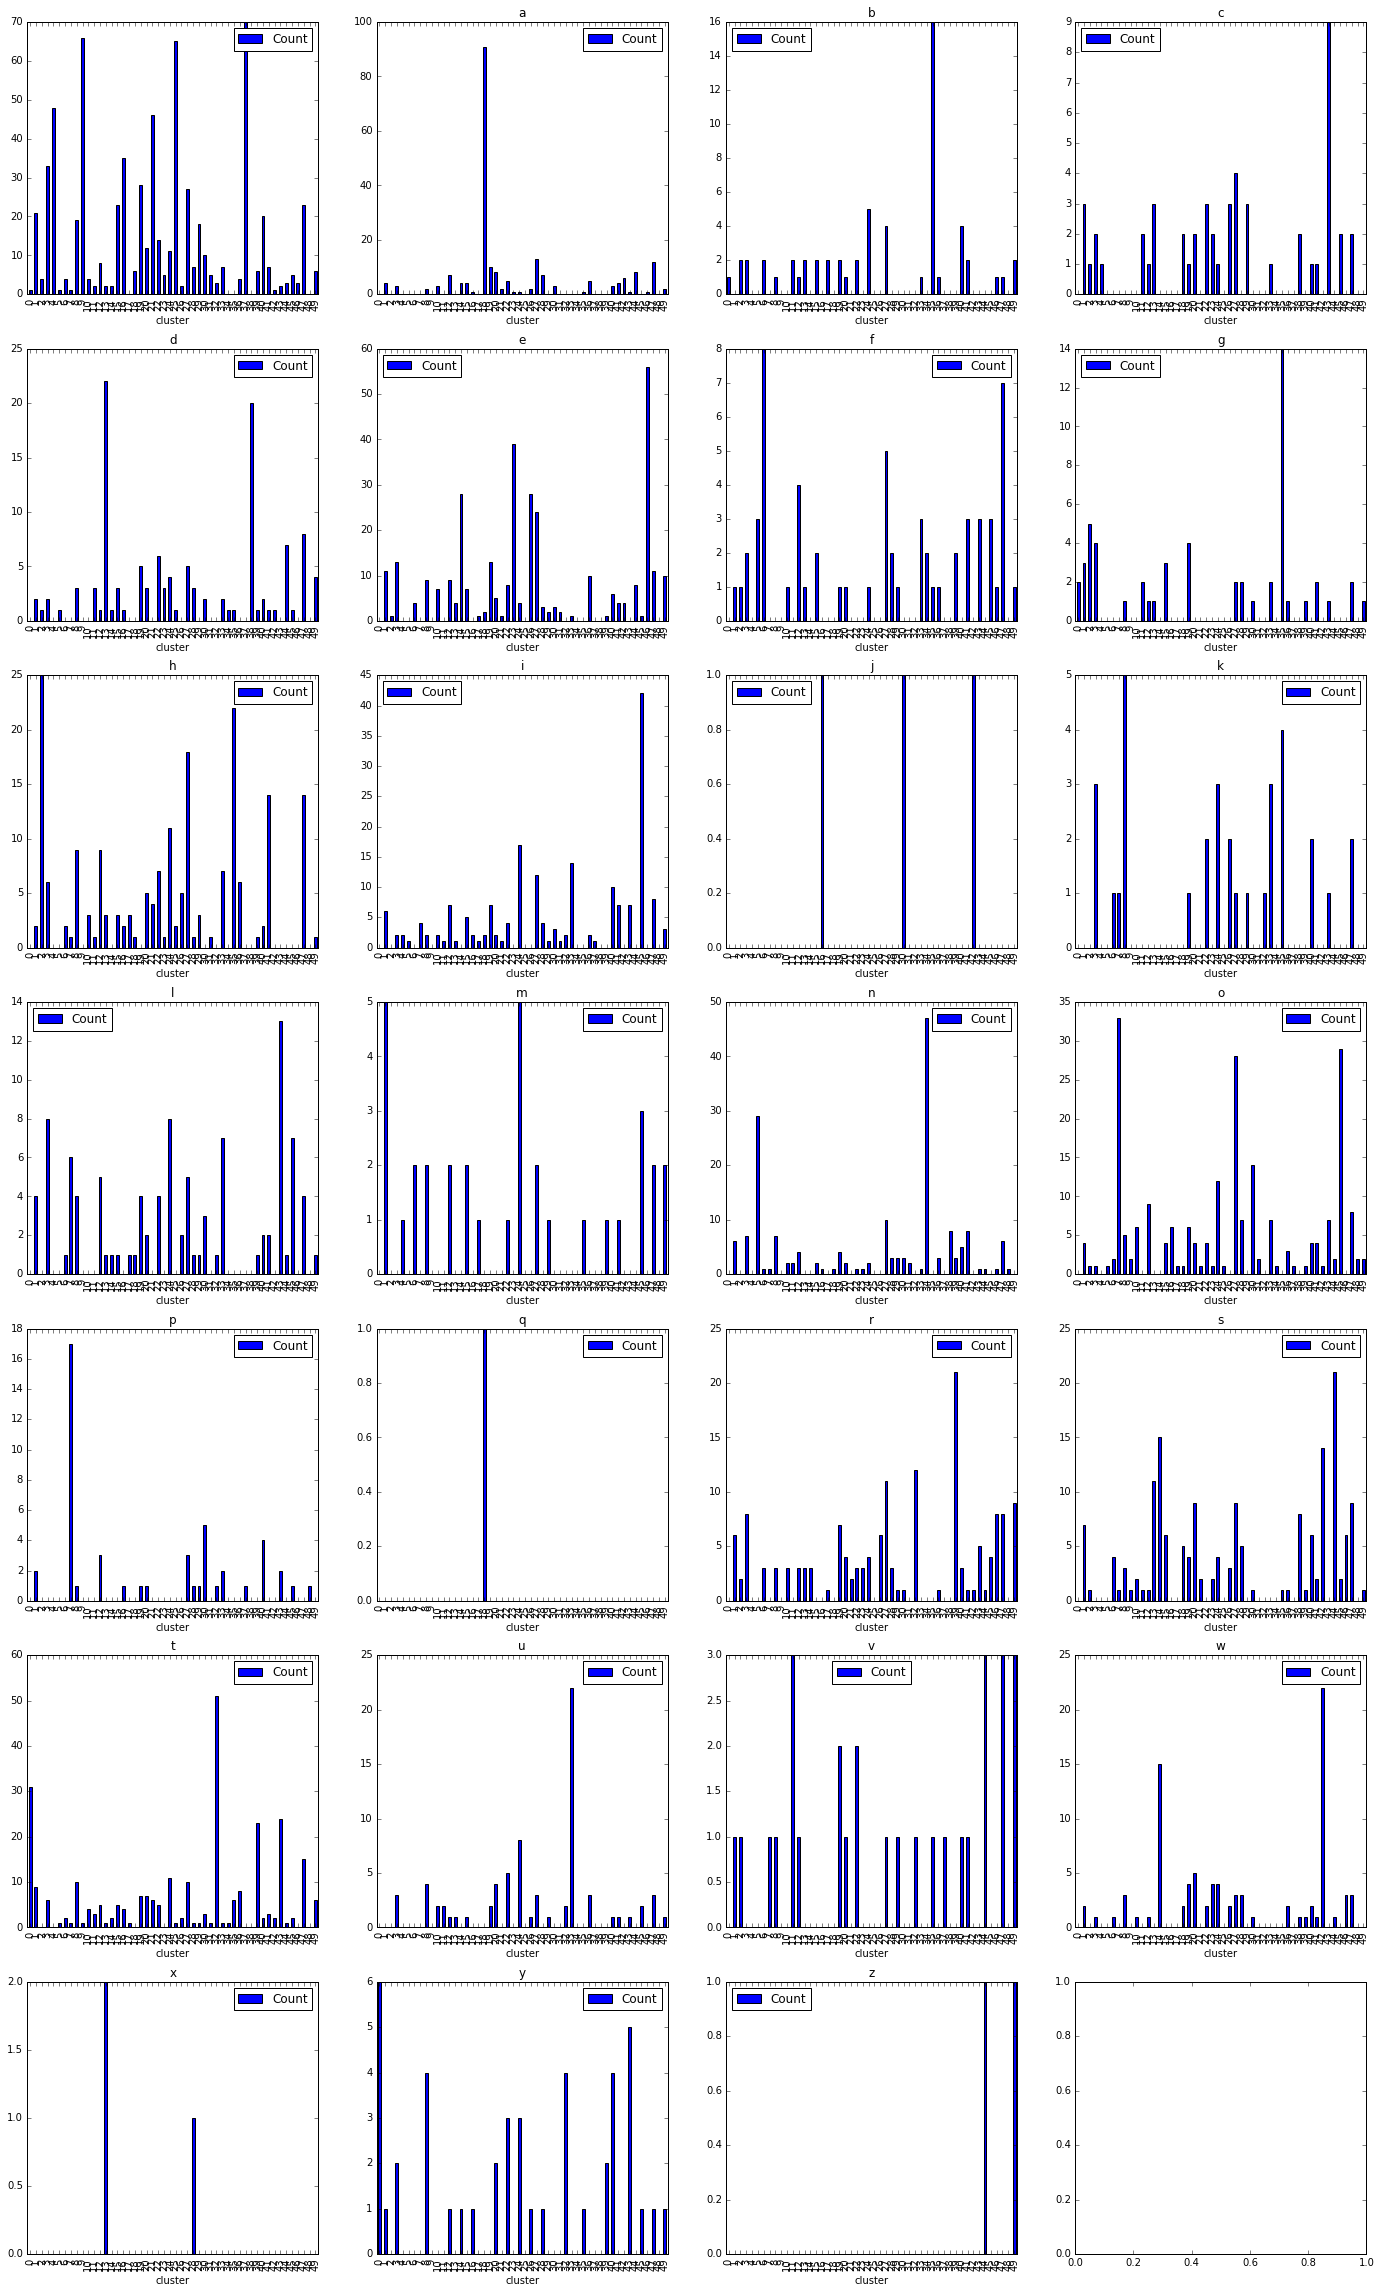

In [111]:
pl.cluster_proportions(cepstrum_df, [' '] + map(lambda x : chr(x + ord('a')),  range(26)), num_clusters = NUM_CLUSTERS)

## Build Transmission Matrix with bigrams

In [112]:
A_df, n_unique, unique_chars, id_to_char, char_to_id  = pl.build_transmission_full()
A_df.head()

,,a,b,c,d,e,f,g,h,i,...,q,r,s,t,u,v,w,x,y,z
,0.090909,0.105473,0.042745,0.031918,0.024273,0.018245,0.034355,0.017727,0.065745,0.057145,...,0.001573,0.015027,0.070500,0.151555,0.013518,0.005900,0.061391,0.000155,0.014727,0.000309
a,0.090909,0.004197,0.021397,0.043657,0.036275,0.001990,0.013904,0.021479,0.005426,0.034075,...,0.000768,0.103269,0.092103,0.117707,0.011909,0.020211,0.009556,0.001611,0.028097,0.001873
b,0.090909,0.115110,0.008946,0.004159,0.001840,0.252724,0.000978,0.000526,0.002005,0.056552,...,0.000072,0.059987,0.018299,0.005560,0.105320,0.001559,0.001820,0.000039,0.067918,0.000106
c,0.090909,0.131224,0.001962,0.019926,0.002360,0.130387,0.001762,0.001196,0.132554,0.055609,...,0.001037,0.036307,0.009097,0.078276,0.030313,0.000620,0.001694,0.000035,0.007541,0.000381
d,0.090909,0.097004,0.033688,0.020866,0.022073,0.149113,0.022253,0.013472,0.025298,0.119567,...,0.001563,0.031455,0.057538,0.086940,0.032335,0.006833,0.027069,0.000151,0.012236,0.000541


##  Check the proportion of spaces across the k means classes

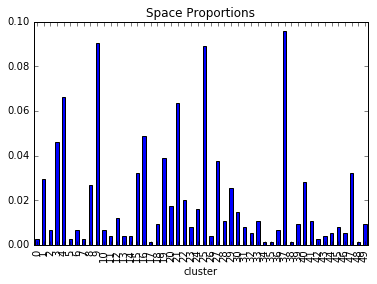

In [114]:
space_props= pl.get_props(cepstrum_df, NUM_CLUSTERS, ' ')
_  = space_props.plot(kind='bar', title = 'Space Proportions')

## Build emissions matrix

In [115]:
Eta = pl.build_eta(cepstrum_df, unique_chars, NUM_CLUSTERS)
Eta

array([[ 0.0027027 ,  0.02972973,  0.00675676, ...,  0.03243243,
         0.00135135,  0.00945946],
       [ 0.01105194,  0.02527638,  0.0118723 , ...,  0.04306455,
         0.00127195,  0.01631878],
       [ 0.03178434,  0.03913285,  0.0175382 , ...,  0.00165961,
         0.00376549,  0.04014442],
       ..., 
       [ 0.00465654,  0.01579693,  0.01588395, ...,  0.03248026,
         0.0239899 ,  0.00852214],
       [ 0.02255323,  0.02428157,  0.03574469, ...,  0.01531048,
         0.03486534,  0.02489993],
       [ 0.02931439,  0.02451332,  0.03773207, ...,  0.03168413,
         0.00774896,  0.03533004]])

## Get Unigram proportions

In [116]:
char_counts = pl.get_char_counts(targ_s, unique_chars)
char_counts

0
a    0.11602
b    0.04702
c    0.03511
d    0.02670
e    0.02007
f    0.03779
g    0.01950
h    0.07232
i    0.06286
j    0.00597
k    0.00590
l    0.02705
m    0.04383
n    0.02365
o    0.06264
p    0.02545
q    0.00173
r    0.01653
s    0.07755
t    0.16671
u    0.01487
v    0.00649
w    0.06753
x    0.00017
y    0.01620
z    0.00034
Name: 1, dtype: float64

## Run HMM

In [120]:
smooth = 0.7
estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                    NUM_CLUSTERS, t_smooth = smooth, tol = TOL,
                                                    do_all = DO_ALL, verbose = True)  
params,_id = build_params(smooth)
params['OVERALL_ACCURACY'] = acc
params['ACCURACY_WO_SPACES'] = acc_wospace
params['PREDICTION'] = estimate
params['SCORE'] = score
params['MODEL'] = hmm

if acc > SAVE_THRESH:
    save(hmm, acc, _id)
else:
    save()

Transmission smoothing: 0.7
Accuracy: 0.15551694179 Without spaces: 0.062613101701
guess:



,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.198697,0.261222


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.143684,0.216044


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.006053,0.004082


In [122]:
estimate

'helld dnd andalloll we ave here s and al dblealy se ive thewhe bl wad thay lld as thebld theally wiver blld levedbed win thavindend alal way aybe ste thelde the sthally say he bescal inglland acodilinendemede al he hat nshe be win han al t alan d wasal sovest d be hel tithealld ts and int hed he asey al and bll alld he ndel he hed ilind ale wad tha ased ind inil agas tendbe nde hesthe dindave wid bedin ad be thealy t t ant lthallaved ad whewa wichellized bl intllly te t t pllasth wad thewede winthesandel t weven wheshe waly thet ng mchel izzed he the waned ghe lllalle he edengathed al heng ben and hivenceizet he he inge paty the blllan whe th athe wan thathe whe we hengal by athe by athe t t her an whe thedbaing int t thaty he bine hasheninin he idthengy th ang lthe tin talit ts awed wsangend ha wind the he tin lsaning the wndeng hiven theinte ave wind t t thaybe t wintis waby t thent the it hed balent wed asebald wheatenghethey wan the he the tin hived theve he hes the sthe hebly ts 

In [121]:
targ_s

'alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book without pictures or conversations so she was considering in her own mind as well as she could for the day made her feel very sleepy and stupid whether the pleasure of making a daisy chai would be worth the trouble of getting up and picking the daisies when sudenly a white rabbit with pink eyes ran close by her there was nothing as remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself oh dear oh dear i shall be too late when she thought it over afterwards it occurred to her that she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually took a watch out of its pocket and burning with curiosity she ran across the field after it and was just about to 

In [125]:
smooths = map(lambda x : np.exp(x), range(-10, 10))
# smooths = np.arange(0,2,.1)
for smooth in smooths:
    estimate, acc, acc_wospace, score, hmm = pl.run_hmm(cepstrum_df, targ_s, 
                                                    NUM_CLUSTERS, t_smooth = smooth, tol = TOL,
                                                    do_all = DO_ALL, verbose = True)  
    params,_id = build_params(smooth)
    params['OVERALL_ACCURACY'] = acc
    params['ACCURACY_WO_SPACES'] = acc_wospace
    params['PREDICTION'] = estimate
    params['SCORE'] = score
    params['MODEL'] = hmm

    if acc > SAVE_THRESH:
        save(hmm, acc, _id)
    else:
        save()
    print estimate

Transmission smoothing: 4.53999297625e-05
Accuracy: 0.253402838112 Without spaces: 0.178429243576
guess:



,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.198697,0.261222


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.143684,0.216044


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.006053,0.004082


aroul sas mandonind sk man aled s lly is squsing in ber sinsas on wis wang and is malond linding jo se onis or sthis axp and ongoly ingi ngangabo ind winker pay owading sig is mastwi wininopr ivedoncarersindy in in aby asas by ssp ube in a mior tind ck whanindd or wands basaind ar bor cap inddindiong in ore ban sing ay pand ay ale minid mit nge sas song may beck mpis pastor ary assqus amanger wis bysapong by iasing a scapl imasplindy me asing s t sinulis on mpaning so ary tindind nge sasanga aman asbedin a asise salsis wong wind ancivian lling sk mas smpre pay nindins ay sasangaure wn blad tor wis acinsts lls in al lllk ting bun buppol war tingsas nge ingsin wan jo ispeck ng byal og bans s acabe me win bangtomer mpindcing g il bler aisjupopre by mysusteg ad med iman ame tinty to mang wingplly ag smid win ay smp iome id bur asalld buine lyjular oun amed t y lammon a juabus wing a paing bun us ily bouply and mistind wing ispindurg amp pan ancowa amp busis asspr un and pay ouay asqug ar b

,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.198697,0.261222


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.143684,0.216044


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.006053,0.004082


arlle whe hethelile me hel ar t o ser pp mberaly he her mprmar bl the maly ply al hambly malllly to to blpe ly meale ave aby heeber alyp tha habe ore warler war asamaly lly ar walimp opellker ansthevereerilly al al aly plar br the mme al a habe wathove onelly t br walsshmampply wo the che aby pasally al her bal hale ar well ar are mamay het the map hore her meve heal warebr her arobur whether the bywhe se by pallly a y per thappppuly he thery the tllurle bl hesllly ys bor allllle the walaler ther tomplll a arare mallar atth hare escinpal ompre st war there har lllllly ar merashauge se mmas abe mor acalenthers al ar mppl wary but blexte the ta thar the pathat wat tr areeve by thar fy mear avecabo he tar matenthes hep s buthy ar bler apleleveve ut herereey te hes thal whe whent th hare womeerer ay thay sat at she llye as bur weeres amate matheer out they tor pathbl a thabul taby a waleh bul us aty bllepr aly horally wath theabrery the war al bar the mmely aster ut all war ourt ambut to m

KeyboardInterrupt: 

,Unnamed: 0,ACCURACY_WO_SPACES,DO_ALL,INPUT_FILE,MAX_COLS,MFCC_START,MODEL,NUM_CLUSTERS,N_COMPONENTS,OVERALL_ACCURACY,PREDICTION,RATE,SCORE,SMOOTH,TOL,WHITEN
0,2016-12-02 06:40:43.549521,0.198697,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.261222,ar he the heronnglo te heo asar t ler is toffo...,44100,-13719.308458,0.018316,0.01,True
1,2016-12-02 06:45:18.224001,0.088672,False,data/perfect_dataset.csv,-1,0,"MultinomialHMM(algorithm='viterbi', init_param...",50,100,0.170866,alear war prcoustea ll pro ff y o wof mp fofro...,44100,-13907.031874,0.018316,0.01,True


In [128]:
save()

                   Unnamed: 0  ACCURACY_WO_SPACES DO_ALL  \
0  2016-12-02 06:40:43.549521            0.198697  False   
1  2016-12-02 06:45:18.224001            0.088672  False   

                 INPUT_FILE  MAX_COLS  MFCC_START  \
0  data/perfect_dataset.csv        -1           0   
1  data/perfect_dataset.csv        -1           0   

                                               MODEL  NUM_CLUSTERS  \
0  MultinomialHMM(algorithm='viterbi', init_param...            50   
1  MultinomialHMM(algorithm='viterbi', init_param...            50   

   N_COMPONENTS  OVERALL_ACCURACY  \
0           100          0.261222   
1           100          0.170866   

                                          PREDICTION   RATE         SCORE  \
0  ar he the heronnglo te heo asar t ler is toffo...  44100 -13719.308458   
1  alear war prcoustea ll pro ff y o wof mp fofro...  44100 -13907.031874   

     SMOOTH   TOL WHITEN  
0  0.018316  0.01   True  
1  0.018316  0.01   True  


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.198697,0.261222


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.143684,0.216044


,ACCURACY_WO_SPACES,OVERALL_ACCURACY
SMOOTH,,
0.018316,0.006053,0.004082
